In [42]:
import random as rn

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.datasets import fashion_mnist
from numpy.random.mtrand import RandomState
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

seed = 42

In [43]:
rn.seed(seed)
np.random.seed(seed)
random_state = RandomState(seed)

def load_data(dataset_name, n_images):
    if dataset_name == "digits":
        x, y = load_digits(return_X_y=True)
        y = y.astype(np.uint8)
        x = x.astype(np.uint8)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=random_state)
        image_hw = np.sqrt(len(x[0])).astype(int)
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        image_hw = x_train.shape[1]
        x_train = x_train.reshape((len(x_train), image_hw ** 2))
        x_test = x_test.reshape((len(x_test), image_hw ** 2))
    if n_images is not None:
        x_train = x_train[:n_images]
        y_train = y_train[:n_images]
    return x_train, y_train, x_test, y_test, {"image_hw": image_hw, "a_max": np.amax(x_test)}

def add_noise(arr, std, data_params_dict):
    arr = arr.astype(float)
    arr += random_state.normal(scale=std, size=arr.shape)
    arr = np.clip(arr, 0, data_params_dict["a_max"])
    arr = np.round(arr).astype(np.uint8)
    return arr

def rotate(arr, angle, data_params_dict):
    image_hw = data_params_dict["image_hw"]
    arr = arr.reshape(image_hw, image_hw).astype(float)
    angle = random_state.uniform(-angle, angle)
    img = Image.fromarray(arr).rotate(angle)
    arr = np.asarray(img)
    arr = np.round(arr).flatten().astype(np.uint8)
    return arr

def get_err_data_lists(x_train, x_test, err_source, err_level, dataset_name, data_params_dict):
    if err_source == "noise":
        error_generator = add_noise
        err_param_name = "std"
        if dataset_name == "digits":
            err_params = np.round(np.linspace(0, 16, num=6), 3)
        else:
            err_params = np.round(np.linspace(0, 255, num=6), 3)
    else:
        error_generator = rotate
        err_param_name = "max_angle"
        err_params = np.linspace(0, 180, num=6)

    if err_level is not None:
        err_x_train_list = [np.apply_along_axis(error_generator, 1, x_train, err_params[err_level], data_params_dict)]
    else:
        err_x_train_list = [np.apply_along_axis(error_generator, 1, x_train, ep, data_params_dict) for ep in err_params]
    err_x_test_list = [np.apply_along_axis(error_generator, 1, x_test, ep, data_params_dict) for ep in err_params]
    return err_x_train_list, err_x_test_list, err_param_name, err_params

def show_examples(err_x_train_list, image_idx, err_params, err_param_name, image_hw):
    _, axs = plt.subplots(2, 3, figsize=(8, 6))
    for i, err_x_train in enumerate(err_x_train_list):
        image_arr = err_x_train[image_idx]
        ax = axs.flatten()[i]
        ax.imshow(image_arr.reshape(image_hw, image_hw), cmap="gray_r") 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{err_param_name}: {err_params[i]}")
    plt.tight_layout()
    plt.show()


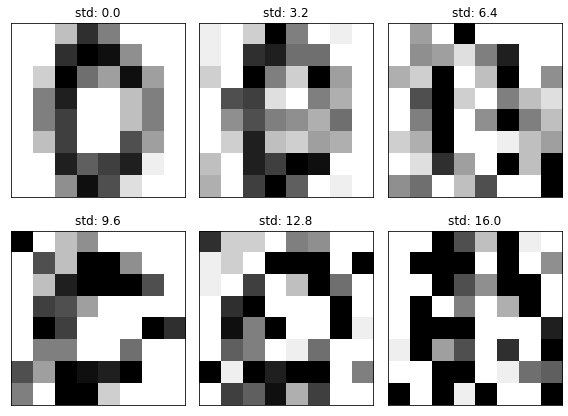

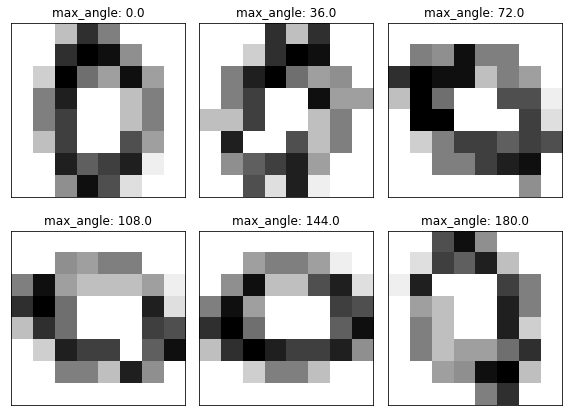

In [44]:
x_train, _, x_test, _, data_params_dict = load_data("digits", 50)
err_x_train_list, _, err_param_name, err_params = get_err_data_lists(
    x_train, x_test, "noise", None, "digits", data_params_dict
)
show_examples(err_x_train_list, 2, err_params, err_param_name, data_params_dict["image_hw"])
err_x_train_list, _, err_param_name, err_params = get_err_data_lists(
    x_train, x_test, "rotation", None, "digits", data_params_dict
)
show_examples(err_x_train_list, 2, err_params, err_param_name, data_params_dict["image_hw"])

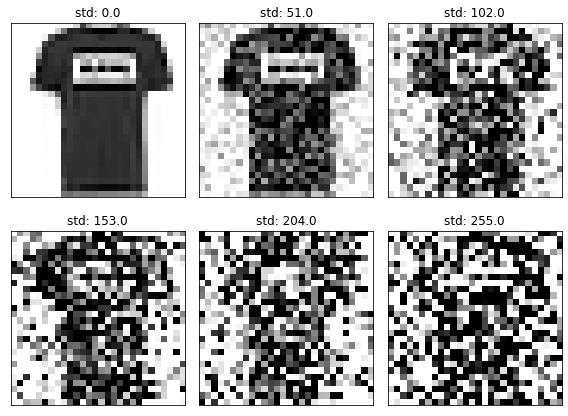

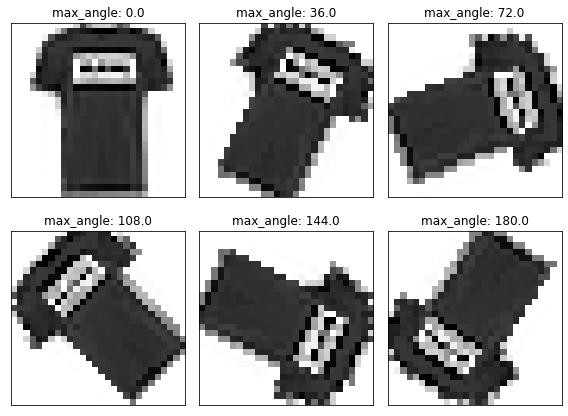

In [45]:
x_train, _, x_test, _, data_params_dict = load_data("fashion", 50)
err_x_train_list, _, err_param_name, err_params = get_err_data_lists(
    x_train, x_test, "noise", None, "fashion", data_params_dict
)
show_examples(err_x_train_list, 1, err_params, err_param_name, data_params_dict["image_hw"])
err_x_train_list, _, err_param_name, err_params = get_err_data_lists(
    x_train, x_test, "rotation", None, "fashion", data_params_dict
)
show_examples(err_x_train_list, 1, err_params, err_param_name, data_params_dict["image_hw"])